In [ ]:
!pip install stellargraph

In [ ]:
import glob
import itertools
from os.path import join
import pickle
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import stellargraph as sg
import tensorflow as tf
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from stellargraph import StellarGraph
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT, GCN
from tensorflow.keras import layers, models, optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils import data as data_utils
from tqdm import tqdm

from google.colab import drive

tqdm.pandas()

## Setting seed value

In [ ]:
seed_value = 1234

tf.random.set_seed(seed_value)
np.random.seed(seed_value)

## Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data loading and preparing

In [ ]:
data_vec = pd.read_csv("/content/drive/Shareddrives/GCN-PROJECT/wiki_pages_vec_1.csv", index_col=0)
data_vec = pd.concat([data_vec, pd.read_csv("/content/drive/Shareddrives/GCN-PROJECT/wiki_pages_vec_2.csv", index_col=0)])
data_vec = pd.concat([data_vec, pd.read_csv("/content/drive/Shareddrives/GCN-PROJECT/wiki_pages_vec_3.csv", index_col=0)])

In [ ]:
print(data_vec.shape)
data_vec.head()

(75443, 4)


,title,text,category,doc_vec
0,Mirosław_Miller,Mirosław Miller – Dyrektor Międzynarodowego La...,Chemia,[-0.21992587 -0.02075839 -0.01461587 0.394395...
1,Chimerokształtne,"Chimerokształtne, chimery, przerazy (Chimaerif...",Biologia,[ 1.14831321e-01 4.09914285e-01 -2.47822907e-...
2,(2855)_Bastian,(2855) Bastian (1931 TB2) – planetoida z grupy...,Astronomia,[-6.03997707e-02 -2.87019789e-01 5.24464190e-...
3,Cryptocephalus_celtibericus,"""Cryptocephalus celtibericus"" – gatunek chrząs...",Biologia,[ 2.02097625e-01 -1.45113677e-01 3.91446799e-...
4,Język_maszynowy,"Język maszynowy, kod maszynowy – zestaw rozkaz...",Matematyka,[ 5.24712503e-01 -9.46738869e-02 1.93830967e-...


In [ ]:
data_vec = data_vec.drop_duplicates(subset=['title'])
data_vec = data_vec.reset_index(drop=True)

In [ ]:
# doc_vec column to list
data_vec['doc_vec'] = data_vec['doc_vec'].progress_apply(
    lambda vec: np.array(
        list(
            map(
                lambda x: float(x),
                vec[1:-1].replace('\n', '').split()
            )
        )
    )
)

100%|██████████| 75301/75301 [00:18<00:00, 3998.52it/s]


In [ ]:
data_vec.iloc[0]['doc_vec'].shape

(768,)

In [ ]:
# Encode target labels with value between 0 and n_classes-1
le = LabelEncoder()
le.fit(data_vec['category'].tolist())
labels = le.transform(data_vec['category'].tolist())

data_vec['category'] = labels

data_vec.head()

,title,text,category,doc_vec
0,Mirosław_Miller,Mirosław Miller – Dyrektor Międzynarodowego La...,2,"[-0.21992587, -0.02075839, -0.01461587, 0.3943..."
1,Chimerokształtne,"Chimerokształtne, chimery, przerazy (Chimaerif...",1,"[0.114831321, 0.409914285, -0.0247822907, 0.14..."
2,(2855)_Bastian,(2855) Bastian (1931 TB2) – planetoida z grupy...,0,"[-0.0603997707, -0.287019789, 0.52446419, 0.01..."
3,Cryptocephalus_celtibericus,"""Cryptocephalus celtibericus"" – gatunek chrząs...",1,"[0.202097625, -0.145113677, 0.391446799, 0.021..."
4,Język_maszynowy,"Język maszynowy, kod maszynowy – zestaw rozkaz...",5,"[0.524712503, -0.0946738869, 0.193830967, 0.39..."


In [ ]:
lookup_dict = dict(enumerate(le.inverse_transform(range(7))))
print(lookup_dict)

data_vec['category'].value_counts()

{0: 'Astronomia', 1: 'Biologia', 2: 'Chemia', 3: 'Fizyka', 4: 'Informatyka', 5: 'Matematyka', 6: 'Psychologia'}


0    25536
1    23393
5     7999
6     5699
3     5070
4     4879
2     2725
Name: category, dtype: int64

## Helper functions

In [ ]:
def conf_matrix(y_true, y_pred):
    labels = tf.unique(y_true)[0].numpy()
    labels.sort()

    con_mat = confusion_matrix(y_true, y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    df_cm = pd.DataFrame(con_mat_norm,
                        index = labels, 
                        columns = [i for i in labels])

    plt.figure(figsize = (10,7))
    plt.title("Confusion matrix")
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

## NN Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
X = data_vec['doc_vec']
y = data_vec['category']

In [ ]:
# split X, y to train and test_val
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=seed_value
)
# split test_val to test and val
X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, test_size=0.5, stratify=y_test_val, random_state=seed_value
)
# 0.5 x 0.3 = 0.15

In [ ]:
print(f'Train: {len(y_train)}')
print(f'Test: {len(y_test)}')
print(f'Val: {len(y_val)}')

Train: 52710
Test: 11295
Val: 11296


In [ ]:
history = model.fit(
    tf.convert_to_tensor(np.stack(X_train)),
    y_train,
    epochs=200,
    validation_data=(tf.convert_to_tensor(np.stack(X_val)), y_val)
)

Epoch 1/200
1648/1648 [==============================] - 4s 2ms/step - loss: 0.5543 - accuracy: 0.8042 - val_loss: 0.3888 - val_accuracy: 0.8544
Epoch 2/200
1648/1648 [==============================] - 4s 3ms/step - loss: 0.3645 - accuracy: 0.8674 - val_loss: 0.3569 - val_accuracy: 0.8739
Epoch 3/200
1648/1648 [==============================] - 4s 3ms/step - loss: 0.3362 - accuracy: 0.8767 - val_loss: 0.3444 - val_accuracy: 0.8776
Epoch 4/200
1648/1648 [==============================] - 4s 2ms/step - loss: 0.3238 - accuracy: 0.8827 - val_loss: 0.3530 - val_accuracy: 0.8762
Epoch 5/200
1648/1648 [==============================] - 4s 2ms/step - loss: 0.3178 - accuracy: 0.8883 - val_loss: 0.3260 - val_accuracy: 0.8827
Epoch 6/200
1648/1648 [==============================] - 4s 3ms/step - loss: 0.3111 - accuracy: 0.8885 - val_loss: 0.3355 - val_accuracy: 0.8857
Epoch 7/200
1648/1648 [==============================] - 5s 3ms/step - loss: 0.2978 - accuracy: 0.8929 - val_loss: 0.3145 - val_ac

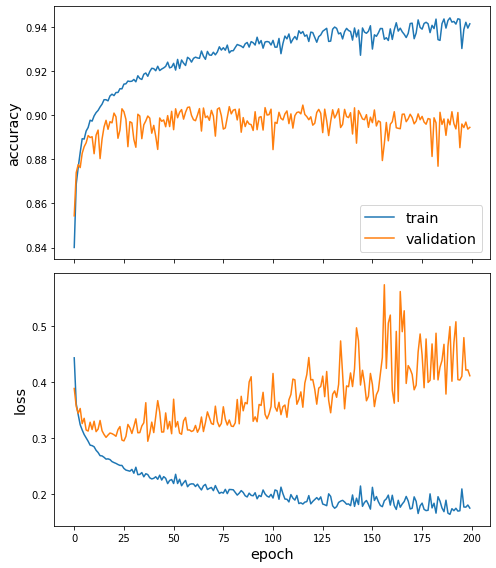

In [ ]:
sg.utils.plot_history(history)

In [ ]:
y_pred = model.predict(tf.convert_to_tensor(np.stack(X_test)))
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.inverse_transform(y_pred)

y_pred[:10]

array(['Biologia', 'Biologia', 'Biologia', 'Matematyka', 'Biologia',
       'Astronomia', 'Informatyka', 'Astronomia', 'Astronomia',
       'Psychologia'], dtype='<U11')

In [ ]:
y_test = np.array(y_test)
y_test = le.inverse_transform(y_test)

y_test[:10]

array(['Biologia', 'Biologia', 'Biologia', 'Matematyka', 'Biologia',
       'Astronomia', 'Informatyka', 'Astronomia', 'Astronomia',
       'Psychologia'], dtype='<U11')

In [ ]:
with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/nn_y_pred.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/nn_y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Astronomia       0.98      0.98      0.98      3830
    Biologia       0.97      0.96      0.97      3509
      Chemia       0.77      0.63      0.69       409
      Fizyka       0.77      0.78      0.77       760
 Informatyka       0.73      0.65      0.69       732
  Matematyka       0.74      0.79      0.76      1200
 Psychologia       0.74      0.81      0.77       855

    accuracy                           0.89     11295
   macro avg       0.81      0.80      0.80     11295
weighted avg       0.89      0.89      0.89     11295



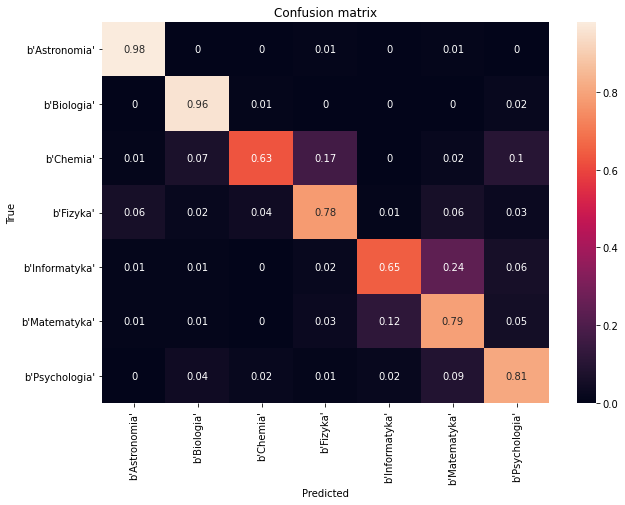

In [ ]:
conf_matrix(
    y_true=y_test,
    y_pred=y_pred
)

## GNN Models

### Data Preparation

In [ ]:
node_data = data_vec[['title', 'doc_vec', 'category']]

features_columns = ['x'+str(i+1) for i in range(node_data.iloc[0]['doc_vec'].shape[0])]

node_data[features_columns] = pd.DataFrame(node_data['doc_vec'].tolist(), index=node_data.index)
node_data = node_data.drop_duplicates(subset=['title'])
node_data = node_data.set_index('title', drop=True)

node_subjects = node_data['category']
node_data = node_data.drop(columns=['doc_vec', 'category'])

In [ ]:
print(node_data.shape)
node_data.head()

(75301, 768)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,...,x729,x730,x731,x732,x733,x734,x735,x736,x737,x738,x739,x740,x741,x742,x743,x744,x745,x746,x747,x748,x749,x750,x751,x752,x753,x754,x755,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765,x766,x767,x768
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Mirosław_Miller,-0.219926,-0.020758,-0.014616,0.394396,0.500316,-0.181580,-0.192722,-0.708210,0.473683,0.439326,0.530582,0.272025,0.634749,0.837265,0.808322,-0.125842,-0.271405,0.617461,0.115456,0.228076,0.463745,0.484825,-0.146430,-0.337708,-0.433751,-0.075304,0.705951,0.631060,0.363307,0.288020,-0.048990,-0.226470,-0.100440,-0.064261,0.232194,0.648149,0.368211,-0.013470,-0.317822,-0.060656,...,0.213190,-0.063614,0.005444,0.213546,0.181618,-0.802018,-0.196133,-0.596286,-0.405018,-0.074901,-0.119138,0.056574,-0.230043,0.504145,-0.108260,0.380613,-0.595839,0.187472,0.191988,0.597606,0.800470,0.386268,0.682949,0.712229,0.677780,-0.639878,0.196495,-0.221351,0.463456,0.331832,-0.671317,0.020494,0.668065,0.771456,0.031702,0.108481,-0.450070,-0.125325,0.289960,0.689580
Chimerokształtne,0.114831,0.409914,-0.024782,0.147265,0.317551,-0.199824,-0.122247,-0.535094,0.422980,0.346967,0.303326,-0.054668,0.672193,0.811492,0.202351,0.153528,-0.840887,0.754388,-0.021899,0.507661,0.335545,0.564200,-0.198836,0.131671,-0.755547,0.035302,0.711862,0.380230,0.467017,0.530130,0.280763,-0.051324,-0.088721,-0.389025,-0.232612,0.523665,0.113089,0.064074,-0.232191,0.006611,...,0.031356,-0.018578,0.332432,-0.196648,0.762116,-0.797382,-0.338181,-0.466067,-0.120869,-0.140519,-0.257714,-0.153664,-0.251419,0.425590,0.277819,0.038872,-0.229557,0.194886,-0.354827,0.601609,0.842410,-0.262562,0.480582,0.076605,-0.104705,-0.636899,0.305006,-0.257087,0.625114,0.616302,-0.737836,0.139394,0.598177,0.801906,-0.031240,0.137388,-0.135596,-0.185398,-0.099210,0.470500
(2855)_Bastian,-0.060400,-0.287020,0.524464,0.010869,0.361838,0.270922,-0.236963,-0.702777,0.067689,0.425118,0.442138,0.185016,0.655864,0.830952,0.150803,0.591725,-0.511207,0.330747,-0.401087,0.287391,-0.089807,0.378315,-0.566631,-0.413916,-0.776283,-0.603583,0.303189,-0.012703,0.590856,0.187999,-0.221558,0.223572,-0.469983,-0.083954,-0.071220,0.753422,-0.133702,0.581880,-0.587725,0.487189,...,0.630668,0.240670,0.202402,-0.318835,0.441645,-0.675024,-0.045359,-0.362277,-0.421742,-0.415869,-0.279742,-0.048752,-0.549688,0.557681,0.302163,0.136112,-0.253669,0.730310,-0.212954,0.617314,0.552607,-0.153099,0.589679,0.493204,0.287557,-0.131214,-0.066009,-0.468578,0.500029,0.368629,-0.822310,0.032054,0.242252,0.553949,-0.267992,-0.344484,-0.136683,-0.226183,0.323400,-0.046518
Cryptocephalus_celtibericus,0.202098,-0.145114,0.391447,0.021200,0.224448,0.032822,-0.430060,-0.290235,0.166879,0.617603,0.428709,0.202603,0.617266,0.769665,0.208997,0.333715,-0.816788,0.776852,-0.100071,0.611350,0.344158,0.621149,-0.235183,0.201298,-0.881020,-0.182275,0.611033,0.520459,0.431674,0.370501,0.067129,-0.278726,-0.125732,-0.575252,0.147851,0.472426,0.093926,0.281920,-0.310783,-0.396964,...,0.148287,-0.003908,0.443697,0.072537,0.438976,-0.864351,-0.243268,-0.407704,-0.162719,0.095343,-0.363262,0.231514,-0.206105,0.184530,0.464446,0.147684,-0.281584,0.328229,-0.450324,0.485036,0.701858,-0.243636,0.860521,0.600689,0.477260,-0.347431,0.265175,-0.420487,0.540403,0.643642,-0.733586,0.092182,0.571006,0.879470,0.016313,-0.177960,-0.367677,-0.120335,0.018981,0.555620
Język_maszynowy,0.524713,-0.094674,0.193831,0.392210,0.570837,-0.178284,-0.076394,-0.511447,0.148328,0.625187,0.195444,-0.005099,0.771912,0.642171,0.559426,-0.025839,-0.317238,0.916364,-0.126402,0.276977,0.355506,0.411032,-0.600609,-0.060925,-0.444267,-0.091692,0.523220,0.651013,0.429251,0.478760,-0.071204,-0.050796,-0.020467,-0.475437,0.168413,0.775962,0.091300,0.159182,-0.319989,-0.524489,...,0.302316,-0.413300,-0.021899,0.437491,0.362457,-0.

In [ ]:
edges = pd.read_csv("/content/drive/Shareddrives/GCN-PROJECT/annotations.csv", header=None)
edges.columns = ['source', 'target']

nodes_set = set(node_data.index)
edges = edges[
    (edges['source'].isin(nodes_set)) &
    (edges['target'].isin(nodes_set))
]

In [ ]:
print(edges.shape)
edges.head()

(346527, 2)


,source,target
0,AWK,Język_programowania
2,AWK,System_operacyjny
3,AWK,Unix
4,AWK,Tablica_asocjacyjna
6,AWK,Wyrażenie_regularne


### StellarGraph

In [ ]:
stellar_graph = StellarGraph(
    {'article': node_data},
    {'annotation': edges}
)

In [ ]:
print(stellar_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 75301, Edges: 346527

 Node types:
  article: [75301]
    Features: float32 vector, length 768
    Edge types: article-annotation->article

 Edge types:
    article-annotation->article: [346527]
        Weights: all 1 (default)
        Features: none


In [ ]:
print(set(node_subjects))
print(len(node_subjects))

{0, 1, 2, 3, 4, 5, 6}
75301


### Data preparation

In [ ]:
# split node_subjects to train and test_val
train_subjects, test_val_subjects = train_test_split(
    node_subjects, test_size=0.3, stratify=node_subjects, random_state=seed_value
)
# split test_val_subjects to test_subjects and val_subjects
test_subjects, val_subjects = train_test_split(
    test_val_subjects, test_size=0.5, stratify=test_val_subjects, random_state=seed_value
)
# 0.5 x 0.3 = 0.15

In [ ]:
print(f'Train: {len(train_subjects)}')
print(f'Test: {len(test_subjects)}')
print(f'Val: {len(val_subjects)}')

Train: 52710
Test: 11295
Val: 11296


In [ ]:
target_encoding = LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)
val_targets = target_encoding.transform(val_subjects)

### GAT

In [ ]:
generator = FullBatchNodeGenerator(stellar_graph, method="gat")

train_gen = generator.flow(train_subjects.index, train_targets)
test_gen = generator.flow(test_subjects.index, test_targets)
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
# gat = GAT(
#     layer_sizes=[128, train_targets.shape[1]],
#     activations=["elu", "softmax"],
#     attn_heads=8,
#     generator=generator,
#     in_dropout=0.5,
#     attn_dropout=0.5,
#     normalize=None,
# )

gat = GAT(
    layer_sizes=[128, 128],
    activations=["elu", "elu"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [ ]:
x_inp, x_out = gat.in_out_tensors()

dense = tf.keras.layers.Dense(units=64, activation="relu")(x_out)
predictions = tf.keras.layers.Dense(units=train_targets.shape[1], activation="softmax")(dense)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
# if not os.path.isdir("logs"):
#     os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
# mc_callback = ModelCheckpoint(
#     "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
# )

In [ ]:
history_gat = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    # callbacks=[es_callback, mc_callback],
    # callbacks=[es_callback],
)

Epoch 1/200
1/1 - 5s - loss: 2.3399 - acc: 0.1164 - val_loss: 4.4931 - val_acc: 0.3391
Epoch 2/200
1/1 - 2s - loss: 4.2635 - acc: 0.3795 - val_loss: 7.8842 - val_acc: 0.3106
Epoch 3/200
1/1 - 2s - loss: 8.6161 - acc: 0.3033 - val_loss: 5.2749 - val_acc: 0.0674
Epoch 4/200
1/1 - 2s - loss: 5.9825 - acc: 0.1370 - val_loss: 2.2667 - val_acc: 0.1062
Epoch 5/200
1/1 - 2s - loss: 3.5068 - acc: 0.1291 - val_loss: 2.1309 - val_acc: 0.3391
Epoch 6/200
1/1 - 2s - loss: 2.6865 - acc: 0.1772 - val_loss: 1.8658 - val_acc: 0.3396
Epoch 7/200
1/1 - 2s - loss: 1.9760 - acc: 0.4460 - val_loss: 1.5863 - val_acc: 0.6255
Epoch 8/200
1/1 - 2s - loss: 2.0494 - acc: 0.4868 - val_loss: 1.5629 - val_acc: 0.5097
Epoch 9/200
1/1 - 2s - loss: 1.8425 - acc: 0.5189 - val_loss: 1.0103 - val_acc: 0.7288
Epoch 10/200
1/1 - 2s - loss: 1.6956 - acc: 0.5241 - val_loss: 1.0986 - val_acc: 0.6481
Epoch 11/200
1/1 - 2s - loss: 1.5936 - acc: 0.5387 - val_loss: 1.0350 - val_acc: 0.6884
Epoch 12/200
1/1 - 2s - loss: 1.3920 - ac

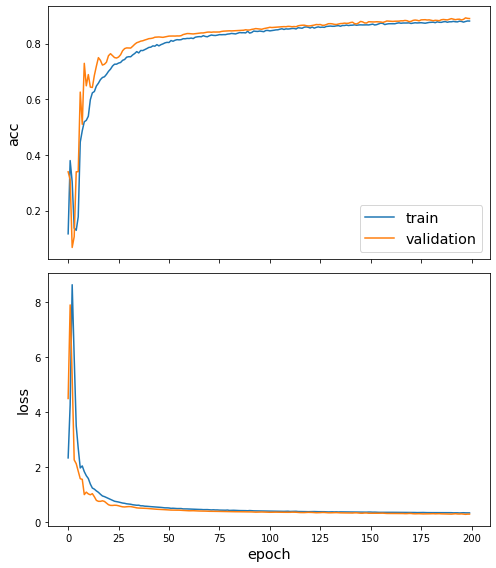

In [ ]:
sg.utils.plot_history(history_gat)

In [ ]:
test_metrics = model.evaluate(test_gen)

print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 1s 711ms/step - loss: 0.3037 - acc: 0.8915

Test Set Metrics:
	loss: 0.3037
	acc: 0.8915


In [ ]:
y_pred = model.predict(test_gen)
y_pred = target_encoding.inverse_transform(y_pred.squeeze())
y_pred = le.inverse_transform(y_pred)

y_pred[:10]

array(['Biologia', 'Biologia', 'Biologia', 'Matematyka', 'Biologia',
       'Astronomia', 'Informatyka', 'Astronomia', 'Astronomia',
       'Psychologia'], dtype='<U11')

In [ ]:
y_test = target_encoding.inverse_transform(test_targets)
y_test = le.inverse_transform(y_test)

y_test[:10]

array(['Biologia', 'Biologia', 'Biologia', 'Matematyka', 'Biologia',
       'Astronomia', 'Informatyka', 'Astronomia', 'Astronomia',
       'Psychologia'], dtype='<U11')

In [ ]:
with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/gat_y_pred.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/gat_y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Astronomia       0.99      0.98      0.98      3830
    Biologia       0.97      0.96      0.96      3509
      Chemia       0.60      0.64      0.62       409
      Fizyka       0.70      0.85      0.77       760
 Informatyka       0.65      0.82      0.73       732
  Matematyka       0.83      0.64      0.72      1200
 Psychologia       0.85      0.77      0.81       855

    accuracy                           0.89     11295
   macro avg       0.80      0.81      0.80     11295
weighted avg       0.90      0.89      0.89     11295



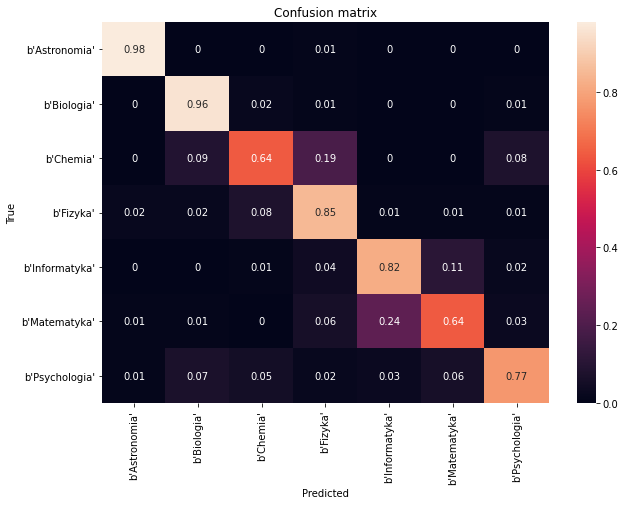

In [ ]:
conf_matrix(
    y_true=y_test,
    y_pred=y_pred
)

### GCN

In [ ]:
generator = FullBatchNodeGenerator(stellar_graph, method="gcn")

train_gen = generator.flow(train_subjects.index, train_targets)
test_gen = generator.flow(test_subjects.index, test_targets)
val_gen = generator.flow(val_subjects.index, val_targets)

Using GCN (local pooling) filters...


In [ ]:
gcn = GCN(
    layer_sizes=[128, 128],
    activations=["elu","elu"],
    generator=generator,
    dropout=0.5
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

dense = tf.keras.layers.Dense(units=64, activation="relu")(x_out)
predictions = tf.keras.layers.Dense(units=train_targets.shape[1], activation="softmax")(dense)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
# if not os.path.isdir("logs"):
#     os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
# mc_callback = ModelCheckpoint(
#     "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
# )

In [ ]:
history_gcn = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    # callbacks=[es_callback, mc_callback],
    # callbacks=[es_callback],
)

Epoch 1/200
1/1 - 1s - loss: 1.9294 - acc: 0.0900 - val_loss: 1.9782 - val_acc: 0.4641
Epoch 2/200
1/1 - 0s - loss: 2.1556 - acc: 0.3124 - val_loss: 2.1576 - val_acc: 0.3391
Epoch 3/200
1/1 - 0s - loss: 2.0870 - acc: 0.3418 - val_loss: 1.7213 - val_acc: 0.3222
Epoch 4/200
1/1 - 0s - loss: 1.8652 - acc: 0.1621 - val_loss: 1.3524 - val_acc: 0.5922
Epoch 5/200
1/1 - 0s - loss: 1.3576 - acc: 0.5187 - val_loss: 1.1669 - val_acc: 0.5845
Epoch 6/200
1/1 - 0s - loss: 1.2000 - acc: 0.5885 - val_loss: 1.0698 - val_acc: 0.6393
Epoch 7/200
1/1 - 0s - loss: 1.1028 - acc: 0.6342 - val_loss: 1.0179 - val_acc: 0.6431
Epoch 8/200
1/1 - 0s - loss: 1.0385 - acc: 0.6392 - val_loss: 0.8673 - val_acc: 0.7396
Epoch 9/200
1/1 - 0s - loss: 0.9102 - acc: 0.7087 - val_loss: 0.7755 - val_acc: 0.7285
Epoch 10/200
1/1 - 0s - loss: 0.8158 - acc: 0.7202 - val_loss: 0.7506 - val_acc: 0.7414
Epoch 11/200
1/1 - 1s - loss: 0.8024 - acc: 0.7061 - val_loss: 0.7067 - val_acc: 0.7602
Epoch 12/200
1/1 - 0s - loss: 0.7714 - ac

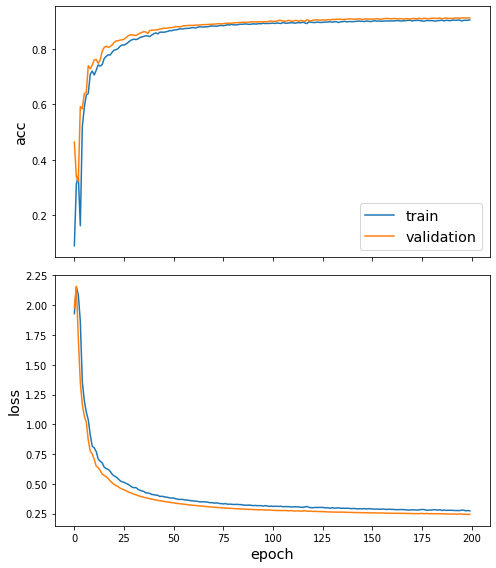

In [ ]:
sg.utils.plot_history(history_gcn)

In [ ]:
test_metrics = model.evaluate(test_gen)

print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 176ms/step - loss: 0.2410 - acc: 0.9130

Test Set Metrics:
	loss: 0.2410
	acc: 0.9130


In [ ]:
y_pred = model.predict(test_gen)
y_pred = target_encoding.inverse_transform(y_pred.squeeze())
y_pred = le.inverse_transform(y_pred)

y_pred[:10]

array(['Biologia', 'Biologia', 'Biologia', 'Matematyka', 'Biologia',
       'Astronomia', 'Informatyka', 'Astronomia', 'Astronomia',
       'Psychologia'], dtype='<U11')

In [ ]:
y_test = target_encoding.inverse_transform(test_targets)
y_test = le.inverse_transform(y_test)

y_test[:10]

array(['Biologia', 'Biologia', 'Biologia', 'Matematyka', 'Biologia',
       'Astronomia', 'Informatyka', 'Astronomia', 'Astronomia',
       'Psychologia'], dtype='<U11')

In [ ]:
with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/gcn_y_pred.pkl', 'wb') as f:
    pickle.dump(y_pred, f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/gcn_y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Astronomia       0.98      0.99      0.99      3830
    Biologia       0.96      0.97      0.97      3509
      Chemia       0.69      0.69      0.69       409
      Fizyka       0.83      0.80      0.82       760
 Informatyka       0.77      0.73      0.75       732
  Matematyka       0.79      0.83      0.81      1200
 Psychologia       0.87      0.81      0.84       855

    accuracy                           0.91     11295
   macro avg       0.84      0.83      0.84     11295
weighted avg       0.91      0.91      0.91     11295



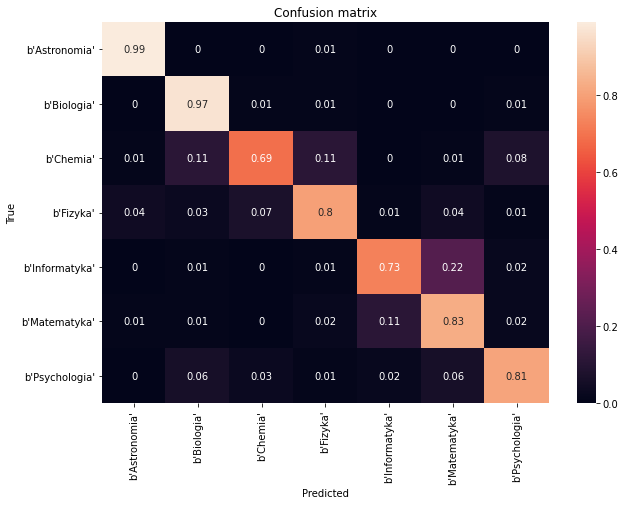

In [ ]:
conf_matrix(
    y_true=y_test,
    y_pred=y_pred
)

# Inne

In [ ]:
import glob
import itertools
from os.path import join
import pickle
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import stellargraph as sg
import tensorflow as tf
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from stellargraph import StellarGraph
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT, GCN
from tensorflow.keras import layers, models, optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils import data as data_utils
from tqdm import tqdm

from google.colab import drive

tqdm.pandas()



import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

from google.colab import drive

In [ ]:
with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/nn_y_pred.pkl', 'rb') as f:
    gcn_2_nn_pred = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/nn_y_test.pkl', 'rb') as f:
    gcn_2_nn_true = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/gat_y_pred.pkl', 'rb') as f:
    gcn_2_gat_pred = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/gat_y_test.pkl', 'rb') as f:
    gcn_2_gat_true = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/gcn_y_pred.pkl', 'rb') as f:
    gcn_2_gcn_pred = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_2_results/gcn_y_test.pkl', 'rb') as f:
    gcn_2_gcn_true = pickle.load(f)

# ---------------------------------------------------------------------------------------------
with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_3_results/onehot140_base_y_pred.pickle', 'rb') as f:
    gcn_3_nn_pred = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_3_results/onehot140_base_y_true.pickle', 'rb') as f:
    gcn_3_nn_true = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_3_results/onehot140_gat_y_pred.pickle', 'rb') as f:
    gcn_3_gat_pred = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_3_results/onehot140_gat_y_true.pickle', 'rb') as f:
    gcn_3_gat_true = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_3_results/onehot140_gcn_y_pred.pickle', 'rb') as f:
    gcn_3_gcn_pred = pickle.load(f)

with open('/content/drive/Shareddrives/GCN-PROJECT/gcn_3_results/onehot140_gcn_y_true.pickle', 'rb') as f:
    gcn_3_gcn_true = pickle.load(f)

In [ ]:
def get_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))


def get_conf_matrix(y_true, y_pred):
    labels = tf.unique(y_true)[0].numpy()
    labels.sort()

    con_mat = confusion_matrix(y_true, y_pred)
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    df_cm = pd.DataFrame(con_mat_norm,
                        index = labels, 
                        columns = [i for i in labels])

    plt.figure(figsize = (10,7))
    plt.title("Confusion matrix")
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

## Podejście 1 - NN

              precision    recall  f1-score   support

  Astronomia       0.98      0.98      0.98      3830
    Biologia       0.97      0.96      0.97      3509
      Chemia       0.77      0.63      0.69       409
      Fizyka       0.77      0.78      0.77       760
 Informatyka       0.73      0.65      0.69       732
  Matematyka       0.74      0.79      0.76      1200
 Psychologia       0.74      0.81      0.77       855

    accuracy                           0.89     11295
   macro avg       0.81      0.80      0.80     11295
weighted avg       0.89      0.89      0.89     11295



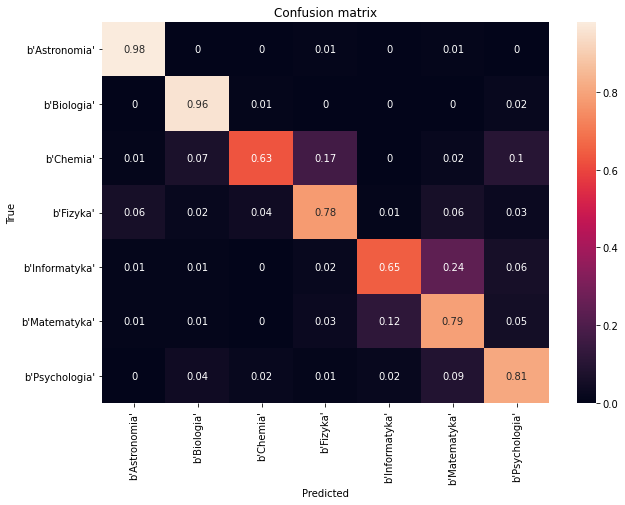

In [ ]:
get_classification_report(gcn_2_nn_true, gcn_2_nn_pred)

get_conf_matrix(gcn_2_nn_true, gcn_2_nn_pred)

              precision    recall  f1-score   support

  Astronomia       0.98      0.99      0.98      3832
    Biologia       0.88      0.97      0.92      3522
      Chemia       0.71      0.53      0.61       416
      Fizyka       0.79      0.69      0.74       768
 Informatyka       0.77      0.75      0.76       738
  Matematyka       0.81      0.75      0.78      1211
 Psychologia       0.85      0.74      0.79       860

    accuracy                           0.89     11347
   macro avg       0.83      0.78      0.80     11347
weighted avg       0.88      0.89      0.88     11347



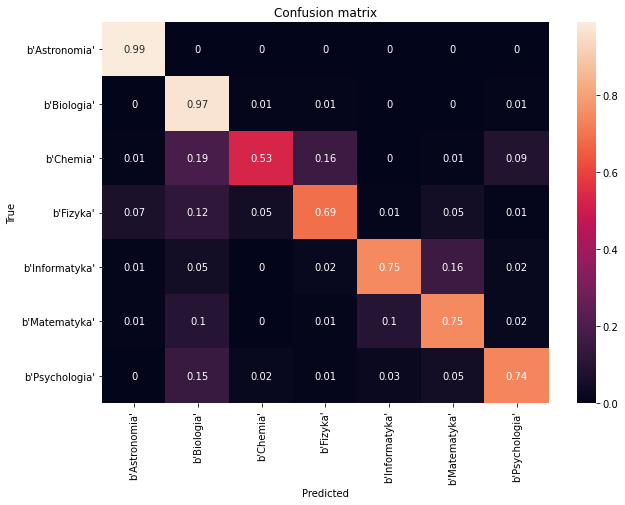

In [ ]:
get_classification_report(gcn_3_gat_true, gcn_3_gat_pred)

get_conf_matrix(gcn_3_gat_true, gcn_3_gat_pred)

              precision    recall  f1-score   support

  Astronomia       0.99      0.99      0.99      3832
    Biologia       0.88      0.97      0.92      3522
      Chemia       0.65      0.55      0.60       416
      Fizyka       0.77      0.70      0.74       768
 Informatyka       0.75      0.74      0.74       738
  Matematyka       0.82      0.73      0.77      1211
 Psychologia       0.83      0.73      0.78       860

    accuracy                           0.88     11347
   macro avg       0.81      0.77      0.79     11347
weighted avg       0.88      0.88      0.88     11347



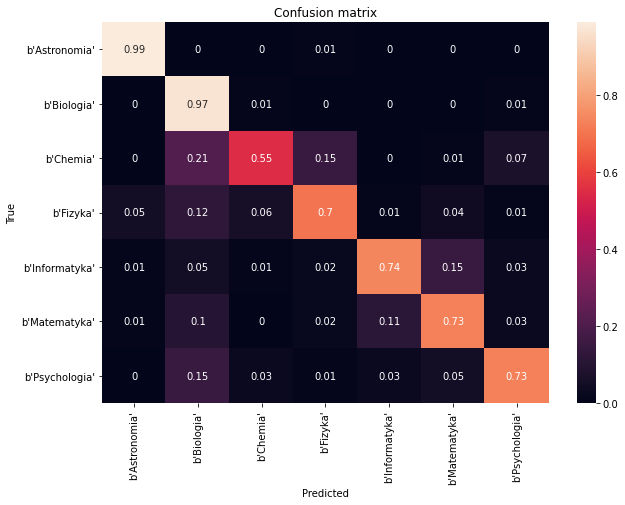

In [ ]:
get_classification_report(gcn_3_gcn_true, gcn_3_gcn_pred)

get_conf_matrix(gcn_3_gcn_true, gcn_3_gcn_pred)

## Podejście 2